In [1]:
import cv2
from imagecorruptions import corrupt, get_corruption_names
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = SummaryWriter(f"runs/DAE", flush_secs=1)
IMG_FOLDER= "JPEGImages"
image_list = glob.glob(f"{IMG_FOLDER}/*.jpg")
train_image_list = image_list[:int(len(image_list)*0.7)]
val_image_list = image_list[int(len(image_list)*0.7):]
IMG_SIZE = (64, 64)
EPOCHS = 500
BATCH_SIZE = 512

In [13]:
def display_img_tensors(img, cor_img, pred):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    img = img.detach().cpu().permute(1,2,0).numpy()
    cor_img = cor_img.detach().cpu().permute(1,2,0).numpy()
    pred = pred.detach().cpu().permute(1,2,0).numpy()
    
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image")

    axes[1].imshow(cv2.cvtColor(cor_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Corrupted Image")

    axes[2].imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Predicted Image")

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_list, img_size=IMG_SIZE):
        super().__init__()
        ### where you define your data source
        self.image_list = image_list
        self.img_size = img_size
        self.corruption_types = get_corruption_names()
        self.corruption_types.remove("glass_blur")
        
    def __getitem__(self, index):
        image = cv2.imread(self.image_list[index])
        image = cv2.resize(image, self.img_size)
        
        c_name = random.sample(self.corruption_types,1)[0]
        corrupt_image = corrupt(image, corruption_name=c_name, severity=1)
        image = image / 255
        corrupt_image = corrupt_image / 255
        image = torch.from_numpy(image).permute(2, 0, 1)
        corrupt_image = torch.from_numpy(corrupt_image).permute(2,0,1)
        
        return corrupt_image.to(torch.float32), image.to(torch.float32)
    
    def __len__(self):
        return len(self.image_list)



In [5]:
train_dataset = ImageDataset(train_image_list)
val_dataset = ImageDataset(val_image_list)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class DenoisingAE(nn.Module):
    def __init__(self, input_shape=IMG_SIZE):
        super().__init__()
        self.encoder = nn.Sequential(
            #inp = 64x64
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),  
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),  
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2), 
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=3, padding=1, stride=2, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1 ),  # Upscale to 4x4
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride=2, output_padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1 ),  
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1, stride=2, output_padding=1),  # Upscale to 64x64
            nn.Sigmoid(),
        )
    def forward(self, image):
        image = image.to(DEVICE)
        enc = self.encoder(image)
        return self.decoder(enc)

In [7]:
model = DenoisingAE()
model = model.to(device=DEVICE)
model.train()
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [15]:
c = 0
for e in tqdm(range(EPOCHS)):
    for corrupt_img, img in train_dataloader:
        corrupt_img, img = corrupt_img.to(DEVICE), img.to(DEVICE)
        pred = model(corrupt_img)
        loss = crit(pred, img)
        writer.add_scalar("Loss/train", scalar_value=loss.item(), global_step=c)
        c+=1
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    writer.flush()
    writer.add_image(f"og after {e} epocs", img[0])
    writer.add_image(f"pred after {e} epocs", pred[0])
    torch.save(model.state_dict(), "DAE.pt")

writer.close()

100%|██████████| 500/500 [4:56:43<00:00, 35.61s/it]  


### I used tensorboard to track my loss hence attaching a screenshot of the graph here, have included tensorboard data in zip file I uploaded
![Loss Graph](img.png)

In [8]:
model.load_state_dict(torch.load('DAE.pt'))

<All keys matched successfully>

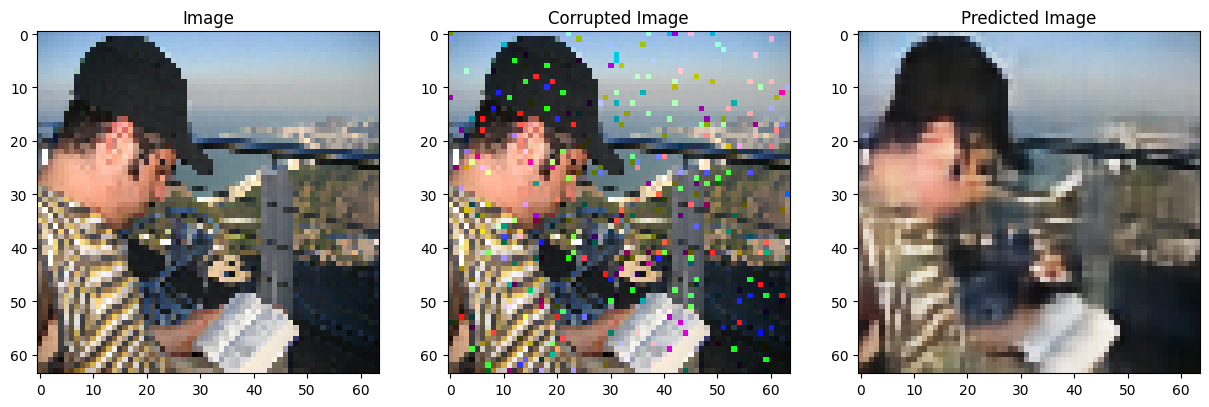

In [15]:
model.eval()
for corrupt_img, img in val_dataloader:
    pred = model(corrupt_img)
    display_img_tensors(img[0], corrupt_img[0], pred[0])
    break